In [1]:
import ROOT as r
import math
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/00


In [2]:
# load data
# four_momenta_LAB = np.load('10M_data/four_momenta_LAB_10M.npy')
# four_momenta_mu_frame = np.load('10M_data/four_momenta_MRF_10M.npy')
Michel_Samples = np.load('10M_data/michel_samples_10M.npy')
# Michel_Samples = np.load('michel_sampled.npy')
MAX_LOOP=Michel_Samples.shape[0]

In [3]:
# global constants
EMMU = 105.6 # mass of muon [MeV] (from PDG)
EMASS = 0.511 # mass of positron [MeV] 
pi = np.pi
twopi = 2*pi
fine_structure_const = 1/137

# michel parameters
michel_rho   = 0.75 # Standard Model Michel rho
michel_delta = 0.75 # Standard Model Michel delta
michel_xsi   = 1.00 # Standard Model Michel xsi
michel_eta   = 0.00 # Standard Model eta

# constants in michel sampling
W_mue  = (EMMU*EMMU+EMASS*EMASS)/(2.*EMMU) # gives the maximum energy of emitted positron (52.8 MeV), neglecting neutrino mass
x0     =  EMASS/W_mue
x0_squared = x0*x0

# variables during michel sampling
rndm =0 # just initialize a random variable
x =0
ctheta =0
FG = 0
FG_max = 2.00

In [4]:
def Lorentz_Boost(x_0,x_1,x_2,x_3,gamma,beta1,beta2,beta3,inverse=False):
    '''
    Implementation of general lorentz boost, from jackson (11.98)
    x is a 4-vector, with components x_0, x_1, x_2, x_3 (minkowski notation with 0,1,2,3 represent ct,x,y,z)
    x can be in K or K' frame, the inverse parameter will take care the correct transformation
    beta1, beta2, beta3 are the components of the velocity of the moving frame K' (K and K' axes are taken to be all parallel to each other)
    
    '''

    if(inverse==True):    # invserse transformation from K' back to K (lab), beta changes sign
        beta1 = -beta1
        beta2 = -beta2
        beta3 = -beta3

    beta_squared = (gamma*gamma - 1) / (gamma*gamma)
        
    #calculate all matrix element of the transformation
    B_00 = gamma

    B_01 = -gamma*beta1

    B_02 = -gamma*beta2

    B_03 = -gamma*beta3


    B_10 = -gamma*beta1

    B_11 = 1+(gamma-1)*(beta1*beta1)/(beta_squared)

    B_12 = (gamma-1)*(beta1*beta2)/(beta_squared)

    B_13 = (gamma-1)*(beta1*beta3)/(beta_squared)


    B_20 = -gamma*beta2

    B_21 = (gamma-1)*(beta2*beta1)/(beta_squared)

    B_22 = 1+(gamma-1)*(beta2*beta2)/(beta_squared)

    B_23 = (gamma-1)*(beta2*beta3)/(beta_squared)


    B_30 = -gamma*beta3

    B_31 = (gamma-1)*(beta3*beta1)/(beta_squared)

    B_32 = (gamma-1)*(beta3*beta2)/(beta_squared)

    B_33 = 1+(gamma-1)*(beta3*beta3)/(beta_squared)


    # calculate the results
    x0_transformed = B_00*x_0 + B_01*x_1 + B_02*x_2 + B_03*x_3

    x1_transformed = B_10*x_0 + B_11*x_1 + B_12*x_2 + B_13*x_3

    x2_transformed = B_20*x_0 + B_21*x_1 + B_22*x_2 + B_23*x_3

    x3_transformed = B_30*x_0 + B_31*x_1 + B_32*x_2 + B_33*x_3

    return [x0_transformed, x1_transformed, x2_transformed, x3_transformed]

In [5]:
def Calculate_Phase(y1, x1, y2, x2):
   # compute the angle difference between vector1 and vector2 given their x,y components. */
   
    ans1 = np.arctan2(y1,x1);  # angle of vector 1, muDecayP
    ans2 = np.arctan2(y2,x2);  # angle of vector 2, muDecayPol
    ans = ans1 - ans2;

    if(ans<0):
        ans = ans+2*np.pi;

    return ans;

In [6]:
# https://gitlab.cern.ch/geant4/geant4/-/blob/master/source/externals/clhep/include/CLHEP/Vector/LorentzVector.h
four_momenta_mu_frame = np.zeros(shape=(MAX_LOOP,6)) # store posiInitE, posiInitPX, posiInitPY ,posiInitPZ (in MRF)

for i in range(MAX_LOOP):
    energy = Michel_Samples[i,0]*W_mue
    if(energy < EMASS):energy = EMASS;
    
    three_momentum = np.sqrt(energy*energy - EMASS*EMASS);
    
    # retrieve E,theta from Michel spectrum
    ctheta = Michel_Samples[i,1]
    stheta = np.sqrt(1.-ctheta*ctheta);
    
    rndm = np.random.uniform(0,1) # generate a random angle phi to fix muon momentum in x,y,z
    phi = twopi * rndm;
    cphi = np.cos(phi);
    sphi = np.sin(phi);
    
    # momentum of the decay positron with respect to the muon spin
    px0 = stheta*cphi*three_momentum ;
    py0 = stheta*sphi*three_momentum ;
    pz0 = ctheta*three_momentum ;
    
    # introduce aritificial spin precession
    rndm = np.random.uniform(0,1)
    alpha= twopi * rndm;
    calpha = np.cos(alpha); # muDecayPolZ i not yet understand, but polarization involve counting, so it is lorentz transformed into itself
    salpha = np.sin(alpha); # muDecayPolX ref: https://arxiv.org/pdf/hep-ph/0409166.pdf
    
    # rotate px py pz wrt 'new' spin direction
    px = calpha*px0 + salpha*pz0
    py = py0
    pz = -salpha*px0 + calpha*pz0
    
    four_momenta_mu_frame[i,0] = energy
    four_momenta_mu_frame[i,1] = px
    four_momenta_mu_frame[i,2] = py
    four_momenta_mu_frame[i,3] = pz
    four_momenta_mu_frame[i,4] = salpha # muDecayPolX
    four_momenta_mu_frame[i,5] = calpha # muDecayPolZ

In [7]:
# lorentz boost parameter (in gm2 experiment)
p_mu_magic = 3.1 # GeV/c (PRL)
gamma_mu = 29.3 # (PRL)
beta_mu_squared = 1-(1/gamma_mu)*(1/gamma_mu) # check the redundancy !
beta_mu = np.sqrt(beta_mu_squared) # calculated from gamma_mu
gamma_tau_mu = 64.4e-6 # sec (PRD)

four_momenta_LAB = np.zeros(shape=(MAX_LOOP,10)) # store the final posiInitE, posiInitPX , posiInitPY, posiInitPZ, cos(angle of z-axis with muon momentum)
# copy the values from previos step
four_momenta_LAB[:,6] = four_momenta_mu_frame[:,4] # muDecayPolZ
four_momenta_LAB[:,7] = four_momenta_mu_frame[:,5] # muDecayPolX  


for i in range(MAX_LOOP):
    # introduce artificial cyclotron motion for muon (using random number to test)
    rndm = np.random.uniform(0,1)
    rot = twopi * rndm;
    crot = np.cos(rot);
    srot = np.sin(rot);
    
    # calculate the velocity components of muon frame in LAB frame
    beta_mu_z = beta_mu*crot
    beta_mu_x = beta_mu*srot
    
    # get 4-momenta in MRF and boost to LAB frame
    E_primed  = four_momenta_mu_frame[i,0] # PosiInitE
    px_primed = four_momenta_mu_frame[i,1] # PosiInitPX
    py_primed = four_momenta_mu_frame[i,2] # PosiInitPY
    pz_primed = four_momenta_mu_frame[i,3] # PosiInitPZ
    
    # lorentz boost
    PosiInitE,PosiInitPX,PosiInitPY,PosiInitPZ= Lorentz_Boost(E_primed,px_primed,py_primed,pz_primed,gamma_mu,beta_mu_x,0,beta_mu_z,inverse=True) 
    four_momenta_LAB[i,0] = PosiInitE
    four_momenta_LAB[i,1] = PosiInitPX
    four_momenta_LAB[i,2] = PosiInitPY
    four_momenta_LAB[i,3] = PosiInitPZ
    
    four_momenta_LAB[i,4] = beta_mu_x # related to muDecayPX
    four_momenta_LAB[i,5] = beta_mu_z # related to muDecayPZ
    
    # calculate g2phase "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)"
    phase = Calculate_Phase(four_momenta_LAB[i,4], four_momenta_LAB[i,5],
                            four_momenta_LAB[i,6], four_momenta_LAB[i,7])
    four_momenta_LAB[i,8] = phase # g2phase
    four_momenta_LAB[i,9] = np.cos(phase) # cos(g2phase)  

In [20]:
r.gInterpreter.Declare("""
//#include <math.h>

double Phase(double y1, double x1, double y2, double x2) {
   /* compute the angle difference between vector1 and vector2 given their x,y components. */
   
   double ans1 = atan2(y1,x1);  //angle of vector 1, muDecayP
   double ans2 = atan2(y2,x2);  //angle of vector 2, muDecayPol
   double ans = ans1 - ans2;
   
   if(ans<0){
       ans = ans+2*M_PI;
    }
       
   return ans;
}
""")

# load gm2ringsim data
fname = "/home/junkai.ng/junkai.ng/CaloMC/gm2ringsim_muon_gasgun_ana_21378178_1.root"
df = r.RDataFrame("G2PhaseAnalyzer/g2phase",fname)
df = df.Define("g2phase", "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)") 
df = df.Define("cosg2phase", "cos(g2phase)") 
varList = ["posiInitE","posiInitPX","posiInitPY","posiInitPZ","g2phase","cosg2phase"]
data_gm2ringsim = df.AsNumpy(columns=varList)

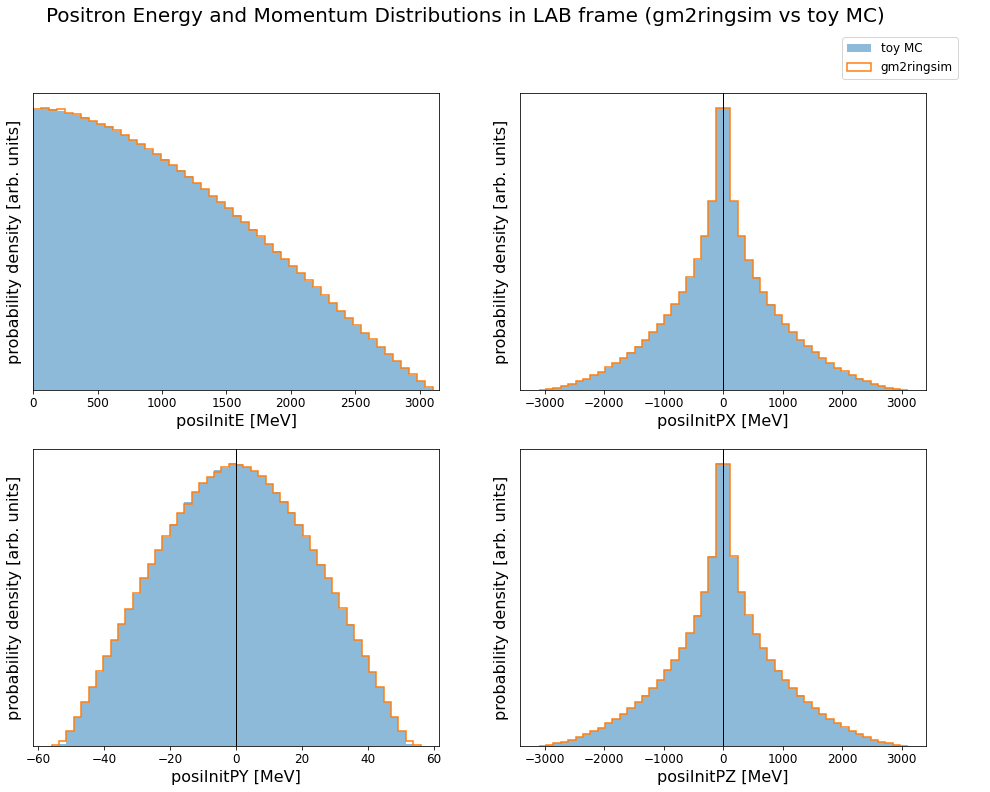

In [9]:
# make a plot to compare with the toy MC data
fig = plt.figure(figsize=(16,12))
fig.suptitle('Positron Energy and Momentum Distributions in LAB frame (gm2ringsim vs toy MC)', fontsize=20)

ax1 = fig.add_subplot(2,2,1)
ax1.hist(four_momenta_LAB[:,0],range=(0,3100),bins=50,density=True,alpha=0.5,label='toy MC')
ax1.hist(data_gm2ringsim['posiInitE'],range=(0,3100),density=True,bins=50,histtype='step',linewidth=1.5,label='gm2ringsim')
ax1.set_xlim([0,3150])
ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("probability density [arb. units]",fontsize=16)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', left=False)
ax1.set_yticklabels([])

ax2 = fig.add_subplot(2,2,2)
ax2.hist(four_momenta_LAB[:,1],range=(-3100,3100),bins=50,density=True,alpha=0.5)
ax2.hist(data_gm2ringsim['posiInitPX'],range=(-3100,3100),bins=50,density=True,histtype='step',linewidth=1.5)
ax2.axvline(color='black', lw=1.0)
ax2.set_xlabel('posiInitPX [MeV]',fontsize=16)
ax2.set_ylabel("probability density [arb. units]",fontsize=16)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', left=False)
ax2.set_yticklabels([])

ax3 = fig.add_subplot(2,2,3)
ax3.hist(four_momenta_LAB[:,2],range=(-56,56),bins=50,density=True,alpha=0.5)
ax3.hist(data_gm2ringsim['posiInitPY'],range=(-56,56),bins=50,density=True,histtype='step',linewidth=1.5)
ax3.axvline(color='black', lw=1.0)
ax3.set_xlabel('posiInitPY [MeV]',fontsize=16)
ax3.set_ylabel("probability density [arb. units]",fontsize=16)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', left=False)
ax3.set_yticklabels([])

ax4 = fig.add_subplot(2,2,4)
ax4.hist(four_momenta_LAB[:,3],range=(-3100,3100),bins=50,density=True,alpha=0.5)
ax4.hist(data_gm2ringsim['posiInitPZ'],range=(-3100,3100),bins=50,density=True,histtype='step',linewidth=1.5)
ax4.axvline(color='black', lw=1.0)
ax4.set_xlabel('posiInitPZ [MeV]',fontsize=16)
ax4.set_ylabel("probability density [arb. units]",fontsize=16)
ax4.tick_params(axis='x', labelsize=12)
ax4.tick_params(axis='y', left=False)
ax4.set_yticklabels([])


fig.legend(loc=(0.85,0.9),fontsize=12)
# plt.savefig('fig_LAB1.png')

In [10]:
# sort out data at different cos(g2phase), for sampled data
filter1 = np.where(abs(four_momenta_LAB[:,9]-1)<=0.4 ) # ctheta= 1
filter2 = np.where(abs(four_momenta_LAB[:,9])<=0.4 )   # ctheta= 0
filter3 = np.where(abs(four_momenta_LAB[:,9]+1)<=0.4 ) # ctheta= -1

four_momenta_lab_filter_1 = four_momenta_LAB[filter1]
four_momenta_lab_filter_2 = four_momenta_LAB[filter2]
four_momenta_lab_filter_3 = four_momenta_LAB[filter3]

In [11]:
# sort out data at different cos(g2phase), for gm2ringsim data
data_gm2ringsim_partial = np.zeros(shape=(2,data_gm2ringsim["posiInitE"].size))
data_gm2ringsim_partial[0] = data_gm2ringsim["posiInitE"]
data_gm2ringsim_partial[1] = data_gm2ringsim["cosg2phase"]
data_gm2ringsim_partial = data_gm2ringsim_partial.T

filter1 = np.where(abs(data_gm2ringsim_partial[:,1]-1)<=0.4 ) # ctheta= 1
filter2 = np.where(abs(data_gm2ringsim_partial[:,1])<=0.4 )   # ctheta= 0
filter3 = np.where(abs(data_gm2ringsim_partial[:,1]+1)<=0.4 ) # ctheta= -1

data_gm2ringsim_partial_filter_1 = data_gm2ringsim_partial[filter1]
data_gm2ringsim_partial_filter_2 = data_gm2ringsim_partial[filter2]
data_gm2ringsim_partial_filter_3 = data_gm2ringsim_partial[filter3]

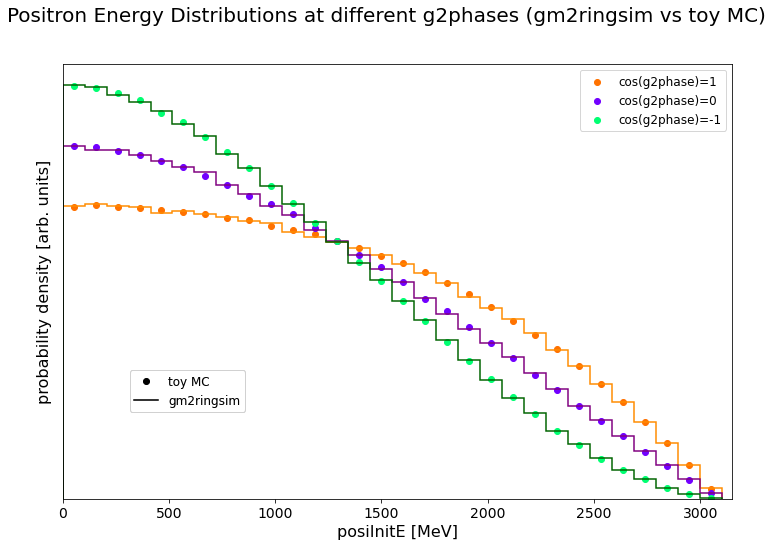

In [12]:
# make a plot to compare with the toy MC data
fig = plt.figure(figsize=(12,8))
fig.suptitle('Positron Energy Distributions at different g2phases (gm2ringsim vs toy MC)', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist(data_gm2ringsim_partial_filter_1[:,0],range=(-3100,3100),bins=60,density=True,color='darkorange',histtype='step',linewidth=1.5)
bin_counts,bin_edges = np.histogram(four_momenta_lab_filter_1[:,0],range=(-3100,3100),bins=60,density=True)
bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
ax1.scatter(bin_midpt,bin_counts,c='#FF7200',label='cos(g2phase)=1')

ax1.hist(data_gm2ringsim_partial_filter_2[:,0],range=(-3100,3100),bins=60,density=True,color='purple',histtype='step',linewidth=1.5)
bin_counts,bin_edges = np.histogram(four_momenta_lab_filter_2[:,0],range=(-3100,3100),bins=60,density=True)
bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
ax1.scatter(bin_midpt,bin_counts,c='#7200FF',label='cos(g2phase)=0')

ax1.hist(data_gm2ringsim_partial_filter_3[:,0],range=(-3100,3100),bins=60,density=True,color='darkgreen',histtype='step',linewidth=1.5)
bin_counts,bin_edges = np.histogram(four_momenta_lab_filter_3[:,0],range=(-3100,3100),bins=60,density=True)
bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
ax1.scatter(bin_midpt,bin_counts,c='#00FF72',label='cos(g2phase)=-1')


ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("probability density [arb. units]",fontsize=16)
ax1.set_xlim([0,3150])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', left=False)
ax1.set_yticklabels([])

lgd1 = ax1.legend(fontsize=12)
ax1.add_artist(lgd1)

import matplotlib.lines as mlines
line1 = mlines.Line2D([], [],linewidth=0, color='black', marker='o', markersize=6, label='toy MC')
line2 = mlines.Line2D([], [],linewidth=1.5, color='black', markersize=8, label='gm2ringsim')
lgd2 = ax1.legend(handles=[line1,line2],fontsize=12,loc=(0.1,0.2))
ax1.add_artist(lgd2)

# plt.savefig('fig_g2phase.png')

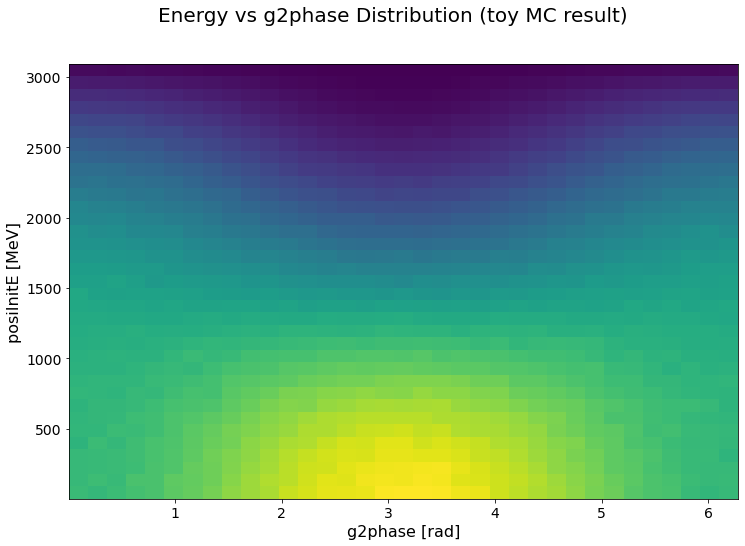

In [13]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Energy vs g2phase Distribution (toy MC result)', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist2d(four_momenta_LAB[:,8],four_momenta_LAB[:,0],bins=(35,35),density=True,cmap='viridis')

ax1.set_xlabel('g2phase [rad]',fontsize=16)
ax1.set_ylabel("posiInitE [MeV]",fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

fig.show()
# plt.savefig('fig_E_v_g2phase.png')

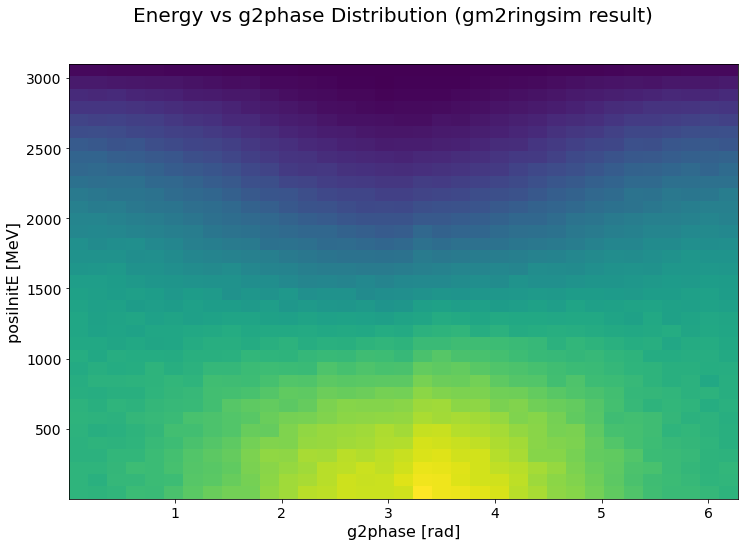

In [21]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Energy vs g2phase Distribution (gm2ringsim result)', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist2d(data_gm2ringsim['g2phase'],data_gm2ringsim['posiInitE'],bins=(35,35),density=True,cmap='viridis')

ax1.set_xlabel('g2phase [rad]',fontsize=16)
ax1.set_ylabel("posiInitE [MeV]",fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

fig.show()
# plt.savefig('fig_E_v_g2phase.png')

# MRF vs LAB PosiInitE

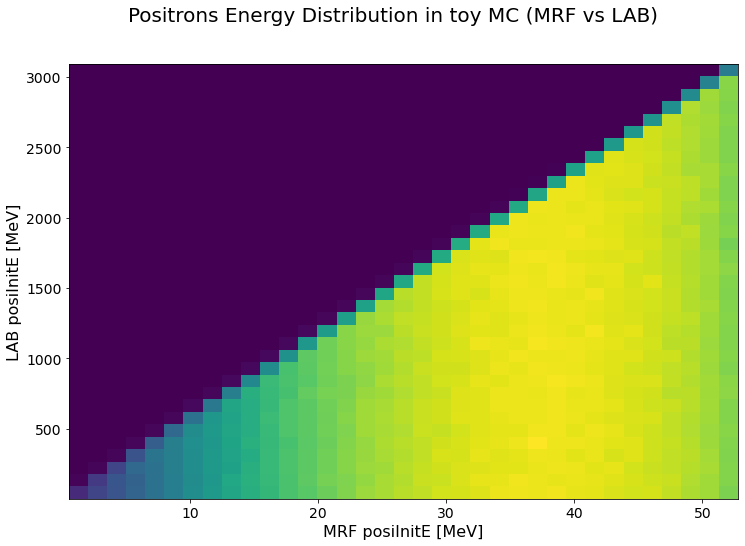

In [15]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Positrons Energy Distribution in toy MC (MRF vs LAB)', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist2d(four_momenta_mu_frame[:,0],four_momenta_LAB[:,0],bins=(35,35),density=True,cmap='viridis')

ax1.set_xlabel('MRF posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("LAB posiInitE [MeV]",fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

fig.show()
# plt.savefig('fig_E_v_g2phase.png')

In [16]:
# sort out data at different MRF energy cut
filter4 = np.where(four_momenta_mu_frame[:,0]>=1 )
filter5 = np.where(four_momenta_mu_frame[:,0]>=5 )
filter6 = np.where(four_momenta_mu_frame[:,0]>=10 )


four_momenta_lab_filter_4 = four_momenta_LAB[filter4]
four_momenta_lab_filter_5 = four_momenta_LAB[filter5]
four_momenta_lab_filter_6 = four_momenta_LAB[filter6]

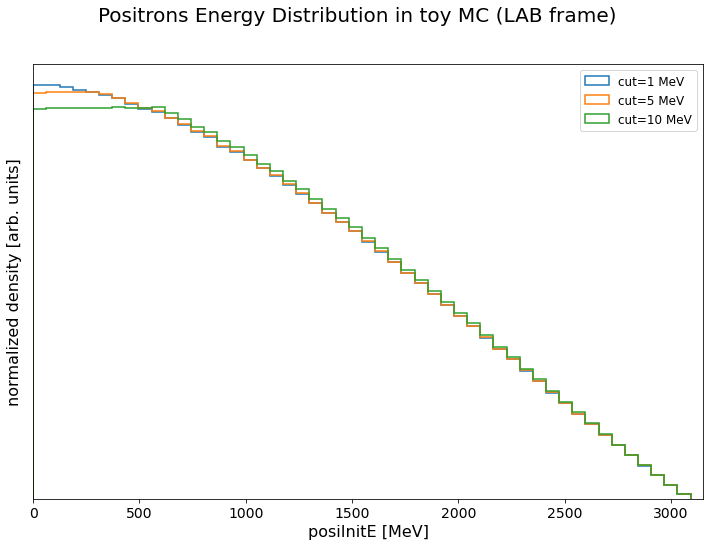

In [17]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Positrons Energy Distribution in toy MC (LAB frame)', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist(four_momenta_lab_filter_4[:,0],bins=50,density=True,histtype='step',linewidth=1.5,label='cut=1 MeV')
ax1.hist(four_momenta_lab_filter_5[:,0],bins=50,density=True,histtype='step',linewidth=1.5,label='cut=5 MeV')
ax1.hist(four_momenta_lab_filter_6[:,0],bins=50,density=True,histtype='step',linewidth=1.5,label='cut=10 MeV')

ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("normalized density [arb. units]",fontsize=16)
ax1.set_xlim([0,3150])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', left=False)
ax1.set_yticklabels([])
ax1.legend(fontsize=12)

# plt.savefig('fig_E_v_g2phase.png')

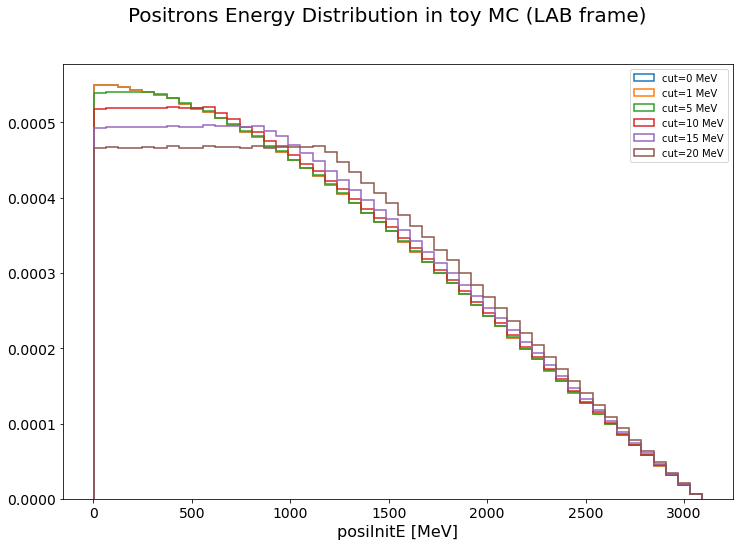

In [18]:
cut = [0,1,5,10,15,20]
fig = plt.figure(figsize=(12,8))
fig.suptitle('Positrons Energy Distribution in toy MC (LAB frame)', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
for cutvalue in cut:
    cut = np.where(four_momenta_mu_frame[:,0]>=cutvalue )
    four_momenta_lab_filter = four_momenta_LAB[cut]
    ax1.hist(four_momenta_lab_filter[:,0],bins=50,density=True,histtype='step',linewidth=1.5,label='cut={} MeV'.format(cutvalue))

ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("",fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.legend()

# plt.savefig('fig_E_v_g2phase.png')